# Determination of Deliquescence

## Initialize Libraries

In [14]:
%matplotlib inline
%pip install ipywidgets numpy matplotlib mplcursors

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Temperature, Vapor Pressure, and Activity Coefficient Relationship

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

# Antoine constants for water (valid 1–100 °C)
A = 8.07131
B = 1730.63
C = 233.426

# Calculate saturation vapor pressure of water at temperature T (°C) in mmHg


def vapor_pressure(T_celsius):
    return 10 ** (A - (B / (C + T_celsius)))

# Compute minimum bubbler temperature given fixture temperature and water activity


def compute_bubbler_temp(T_fixture, a_w):
    P_required = a_w * vapor_pressure(T_fixture)
    # Search for temperature where vapor pressure >= required
    for T_bubbler in np.linspace(0, 100, 1000):
        if vapor_pressure(T_bubbler) >= P_required:
            return T_bubbler
    return np.nan

# Main interactive plot function


def interactive_plot(T_fixture=90.0, a_w=0.25):
    T_bubbler = compute_bubbler_temp(T_fixture, a_w)
    print(f"Fixture Temperature: {T_fixture:.1f} °C")
    print(f"Water Activity (a_w): {a_w:.2f}")
    print(f"→ Minimum Bubbler Temperature: {T_bubbler:.2f} °C (at 100% RH)")

    # Plot vapor pressure curve and thresholds
    T_range = np.linspace(0, 100, 500)
    P_curve = vapor_pressure(T_range)
    P_required = a_w * vapor_pressure(T_fixture)

    plt.figure(figsize=(8, 5))
    plt.plot(T_range, P_curve, label='Vapor Pressure of Water (mmHg)')
    plt.axhline(P_required, color='red', linestyle='--',
                label=f'Required Vapor Pressure = {P_required:.1f} mmHg')
    plt.axvline(T_bubbler, color='green', linestyle='--',
                label=f'Min Bubbler Temp = {T_bubbler:.1f} °C')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Saturation Vapor Pressure (mmHg)')
    plt.title('Required vs. Actual Vapor Pressure for Deliquescence')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Create interactive sliders
interact(
    interactive_plot,
    T_fixture=FloatSlider(value=90, min=30, max=105, step=1,
                          description='Fixture Temp (°C)'),
    a_w=FloatSlider(value=0.25, min=0.05, max=1,
                    step=0.01, description='Water Activity')
)

interactive(children=(FloatSlider(value=90.0, description='Fixture Temp (°C)', max=105.0, min=30.0, step=1.0),…

<function __main__.interactive_plot(T_fixture=90.0, a_w=0.25)>

## Osmotic Coefficient and Actvity Coefficent Relationship

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
import math

# Constants
M_w = 0.018015  # kg/mol (molecular weight of water)
nu = 2        # van't Hoff factor for NaI → Na⁺ + I⁻

# Compute water activity from osmotic coefficient and molality


def water_activity(phi, molality):
    ln_aw = - (phi * nu * molality * M_w)
    return np.exp(ln_aw)

# Interactive plot


def interactive_aw_plot(phi=1.1, molality=5.0):
    aw = water_activity(phi, molality)
    print(f"Osmotic Coefficient (ϕ): {phi:.2f}")
    print(f"Molality (mol/kg H₂O): {molality:.2f}")
    print(f"→ Water Activity (a_w): {aw:.5f}")

    # Simple visualization
    molality_vals = np.linspace(0.1, 12, 200)
    aw_vals = [water_activity(phi, m) for m in molality_vals]

    plt.figure(figsize=(8, 5))
    plt.plot(molality_vals, aw_vals, label=f'ϕ = {phi:.2f}')
    plt.axvline(molality, color='green', linestyle='--',
                label=f'Selected Molality = {molality:.2f}')
    plt.axhline(aw, color='red', linestyle='--', label=f'a_w = {aw:.5f}')
    plt.xlabel('Molality (mol/kg H₂O)')
    plt.ylabel('Water Activity (a_w)')
    plt.title('Water Activity vs. Molality (at fixed Osmotic Coefficient)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Create interactive sliders
interact(
    interactive_aw_plot,
    phi=FloatSlider(value=1.1, min=0.8, max=2.2, step=0.01,
                    description='ϕ (Osmotic Coeff)'),
    molality=FloatSlider(value=5.0, min=0.1, max=12.0,
                         step=0.1, description='Molality (mol/kg)')
)

interactive(children=(FloatSlider(value=1.1, description='ϕ (Osmotic Coeff)', max=2.2, min=0.8, step=0.01), Fl…

<function __main__.interactive_aw_plot(phi=1.1, molality=5.0)>

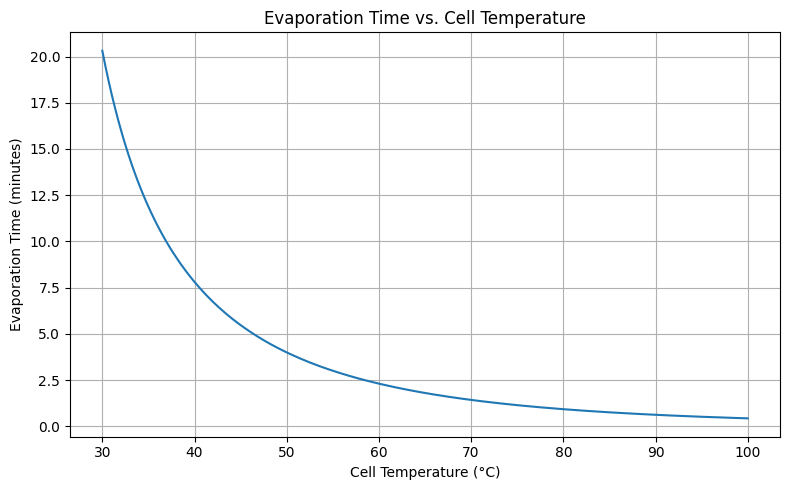

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import mplcursors  # <- for mouse tracking
import math

# Constants
M_w = 0.018015  # kg/mol (molecular weight of water)
R = 8.314  # J/(mol·K) (universal gas constant)
N_a = 6.022e23  # molecules/mol (Avogadro's number)
A_channel = 0.003175 * 0.0127  # m² (1/8" x 1/2")
MMHG_TO_PA = 133.322  # 1 mmHg = 133.322 Pa
density_water = 997  # kg/m³

# Antoine coefficients for water (valid between 1-100°C)
A = 8.07131
B = 1730.63
C = 233.426


def vapor_pressure(T_celsius):
    """Returns vapor pressure in Pascals"""
    return 10 ** (A - (B / (C + T_celsius))) * MMHG_TO_PA


def rate_evap(t_cell, t_rt=20):
    """Returns evaporation rate in molecules per second"""
    delta_p = vapor_pressure(t_cell) - vapor_pressure(t_rt)
    return (delta_p * N_a * A_channel) / (math.sqrt(2 * math.pi * M_w * R * (t_cell + 273.15)))

def time_evap(t_cell, t_rt=20, volume_mL=100):
    volume_m3 = volume_mL * 1e-6
    mass = volume_m3 * density_water  # in kg
    moles = mass / M_w  # mol
    molecules = moles * N_a
    rate = rate_evap(t_cell, t_rt)  # molecules/sec
    return (molecules / rate) / 60  # minutes


# Plot
plt.figure(figsize=(8, 5))
t_cell_range = np.linspace(30, 100, 200)
evap_times = [time_evap(t) for t in t_cell_range]
line, = plt.plot(t_cell_range, evap_times, label='Evaporation Time')

plt.xlabel('Cell Temperature (°C)')
plt.ylabel('Evaporation Time (minutes)')
plt.title('Evaporation Time vs. Cell Temperature')
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
vapor_pressure(50)/101325

0.12144688555294282